### Solution 1
Environment Observation Type: **Kinematics** \
Agent Action Type: **DiscreteMetaAction** \
Algorithm Used: **A2C**

### Overview
The project involves developing a reinforcement learning (RL) agent using the Advantage Actor-Critic (A2C) algorithm to solve the Highway environment. The goal is to train an agent to maximize speed while minimizing the crash risk, optimizing decision-making using RL algorithms, exploring and expanding the reward system, and enhancing interpretability and analysis of the agent's decisions.

### Environment Configuration
The configuration for the Highway environment is specified with fixed parameters for lanes, vehicle count, duration, other vehicles' behavior, and initial spacing. The observation type is set to Kinematics, and the action type is DiscreteMetaAction. Certain reward-related parameters can be modified to optimize training.

### A2C Algorithm
Advantage Actor-Critic (A2C) is an RL algorithm that combines the benefits of value-based and policy-based methods. It consists of two networks: an actor network that decides the actions to take and a critic network that evaluates the actions by estimating the value function.

### Observation and Action Interactions:

- Observations: The agent receives observations in the form of Kinematics, which include the position, speed, and other dynamic parameters of the vehicles on the highway. This helps the agent understand the environment's state.
- Actions: The agent uses DiscreteMetaAction, which includes actions like lane changes and acceleration. These discrete actions allow the agent to navigate the highway, change lanes, and control speed to avoid collisions and maintain high speed.

#### How the A2C works

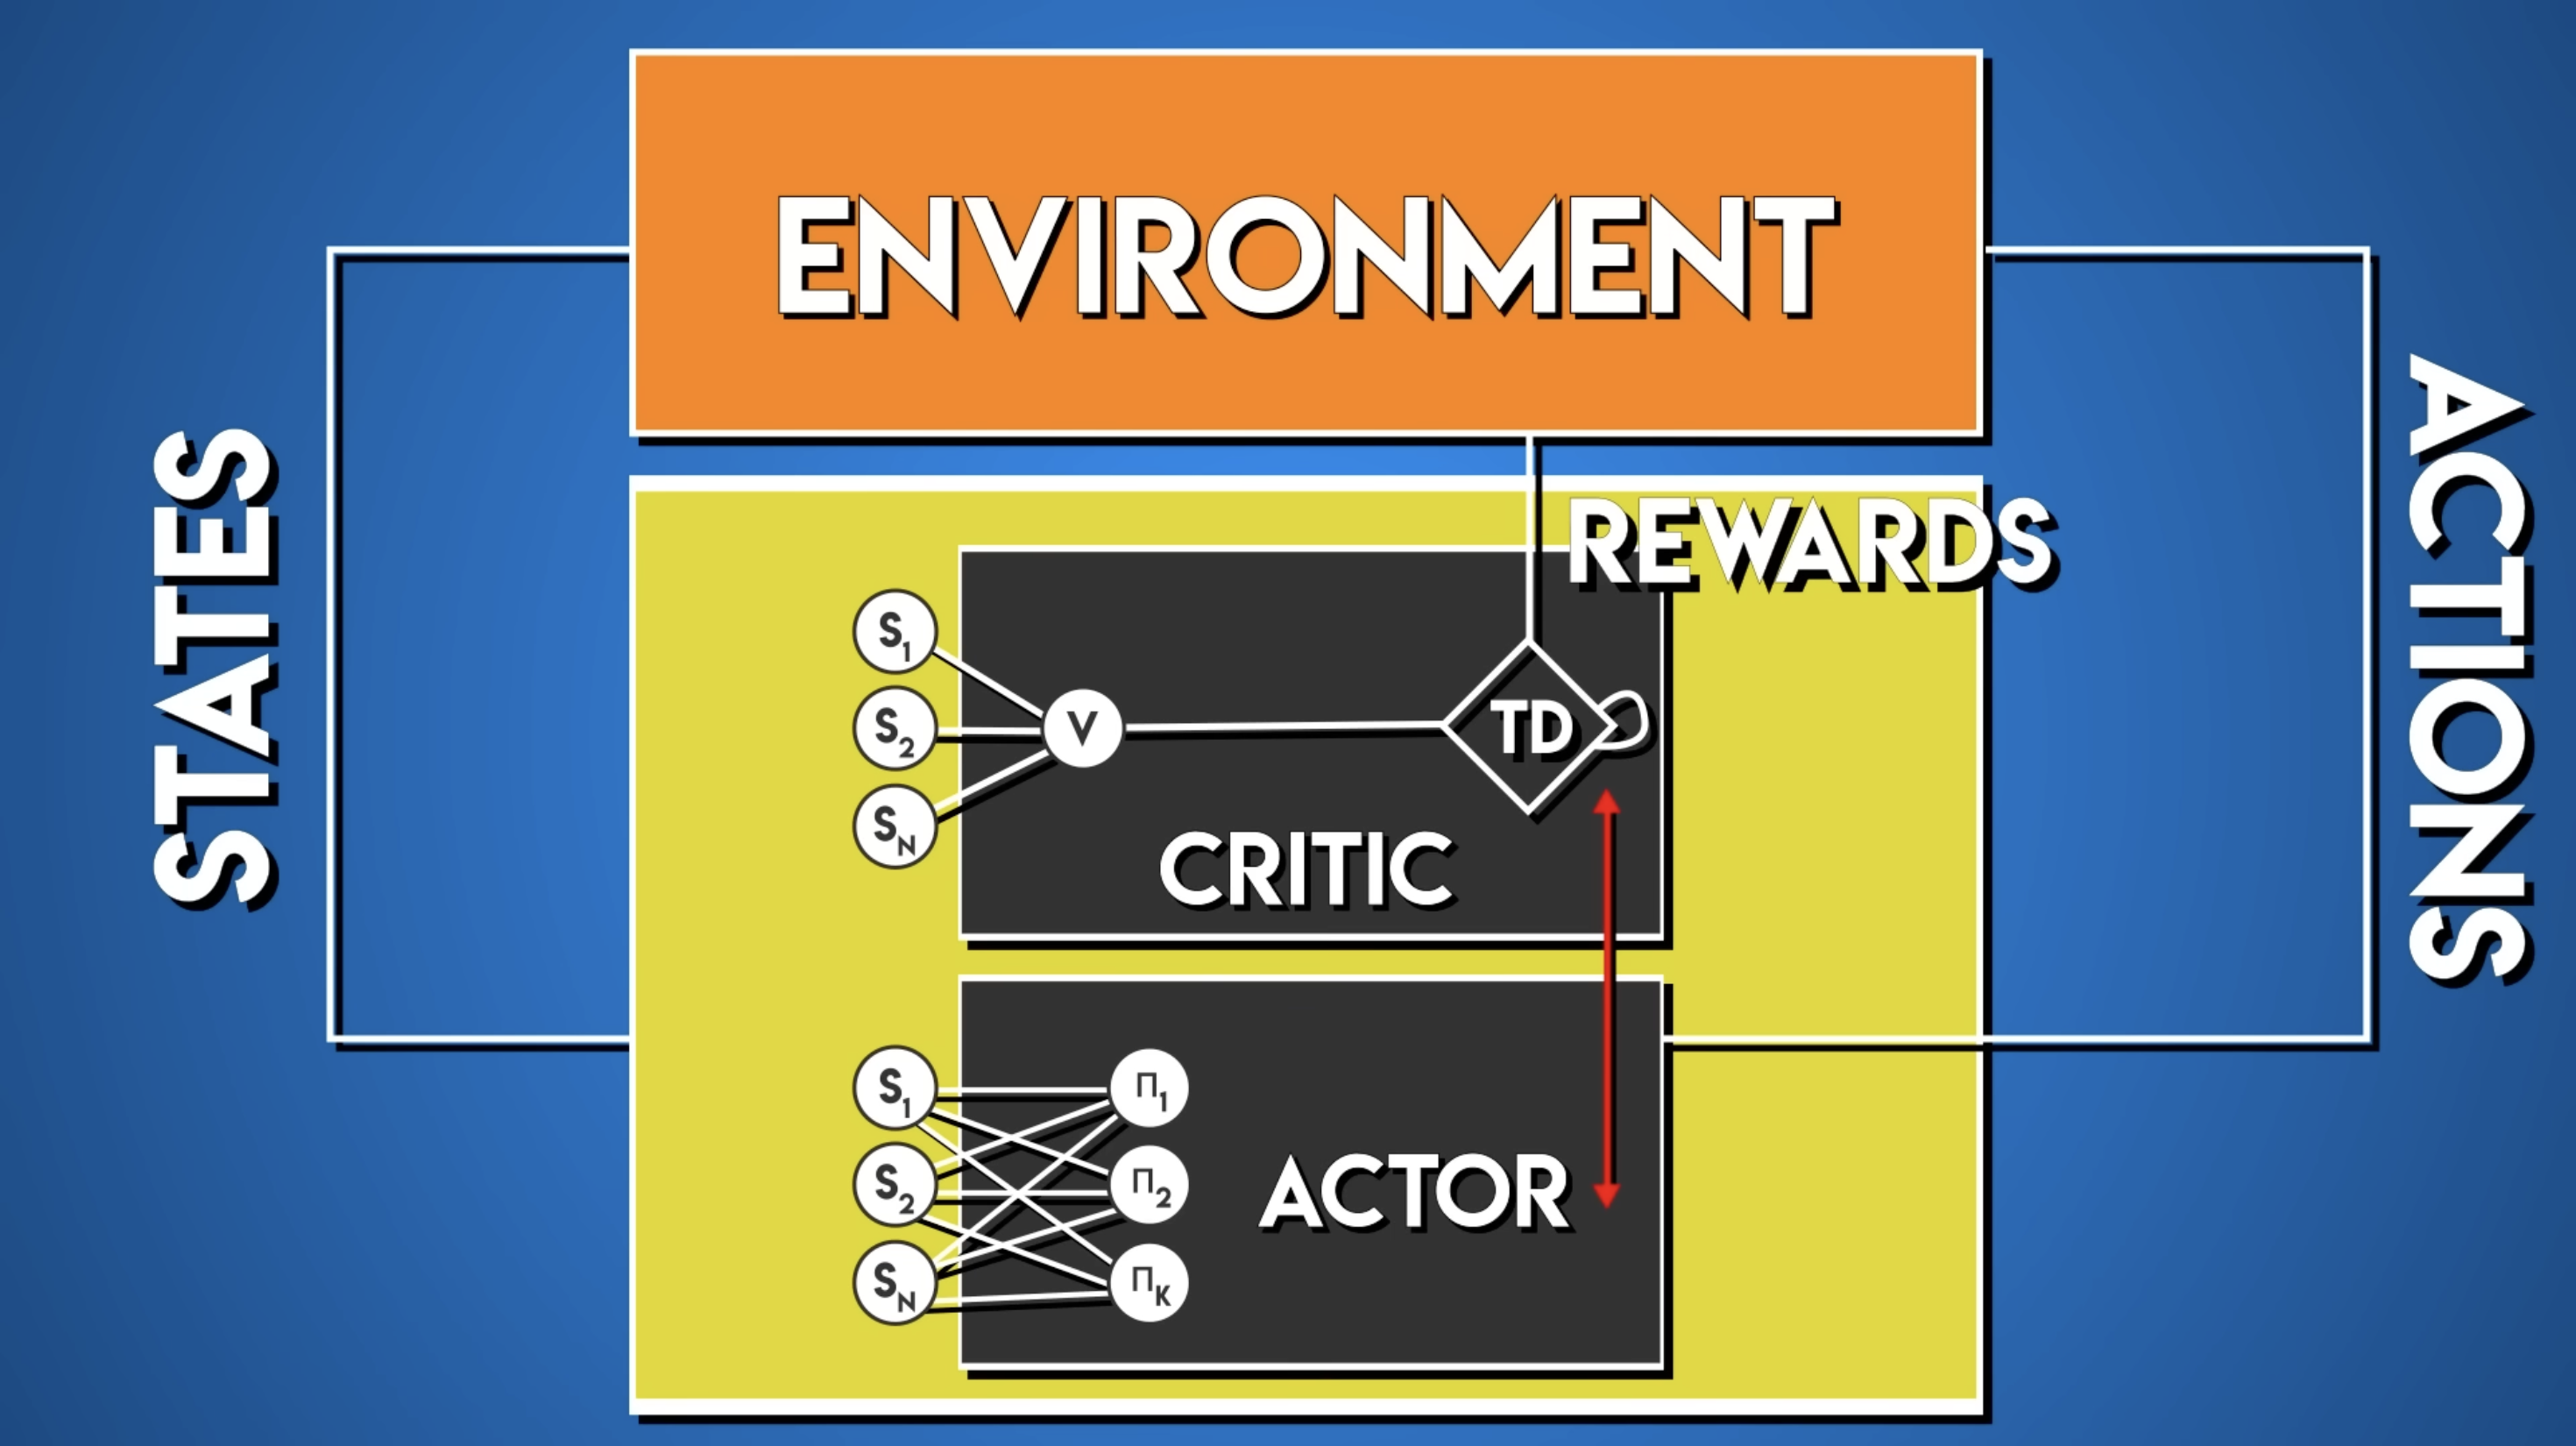

In [31]:
import gymnasium as gym
import highway_env
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from collections import deque
import random
from abc import ABC, abstractmethod
import logging
from functools import partial
from collections.abc import Mapping
from gymnasium.utils import seeding
import copy
import math
from stable_baselines3 import A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.noise import NormalActionNoise
from highway_env.envs.highway_env import HighwayEnv

In [21]:
config = {

    # Parametrization bellow cannot be changed
    "lanes_count": 4, # The environment must always have 10 lanes
    "vehicles_count": 50, # The environment must always have 50 other vehicles
    "duration": 40,  # [s] The environment must terminate never before 120 seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle", # This is the policy of the other vehicles
    "initial_spacing": 2, # Initial spacing between vehicles needs to be at most 2

    # Refer to refer to https://highway-env.farama.org/observations/ to change observation space type
    "observation": {
        "type": "Kinematics"
    },

    # Refer to refer to https://highway-env.farama.org/actions/ to change action space type
    "action": {
        "type": "DiscreteMetaAction",
    },

    # Parameterization bellow can be changed (as it refers mostly to the reward system)
    "collision_reward": -1,  # The reward received when colliding with a vehicle. (Can be changed)
    "reward_speed_range": [20, 30],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD]. (Can be changed)
    "simulation_frequency": 15,  # [Hz] (Can be changed)
    "policy_frequency": 1,  # [Hz] (Can be changed)
    
    # Parameters defined bellow are purely for visualiztion purposes! You can alter them as you please
    "screen_width": 800,  # [px]
    "screen_height": 600,  # [px]
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False
}

In [22]:
env = gym.make("highway-v0", render_mode='human')
env.unwrapped.configure(config)
env.reset()
env = Monitor(env)  # Wrap the environment to monitor and record desired statistics

In [27]:
# Initialize the A2C model
a2c_model = A2C("MlpPolicy", env, verbose=1)

# Train the A2C model
a2c_model.learn(total_timesteps=10000, log_interval=100) # Set to 10, so the training progress will be logged every 10 steps.
a2c_model.save("a2c_highway")
vec_env = a2c_model.get_env()

# Evaluate the A2C model
mean_reward, std_reward = evaluate_policy(a2c_model, vec_env, n_eval_episodes=30) # Set to 30 for a more statistically significant estimate of the policy's performance.
print(f"Mean reward: {mean_reward} +/- {std_reward}")

Using cpu device
Wrapping the env in a DummyVecEnv.
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 22.5      |
|    ep_rew_mean        | 16.5      |
| time/                 |           |
|    fps                | 6         |
|    iterations         | 100       |
|    time_elapsed       | 82        |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -1.54     |
|    explained_variance | -0.000769 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -13.4     |
|    value_loss         | 113       |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 23.2     |
|    ep_rew_mean        | 17       |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 200      |
|    time_elapsed       | 165      |
|    t

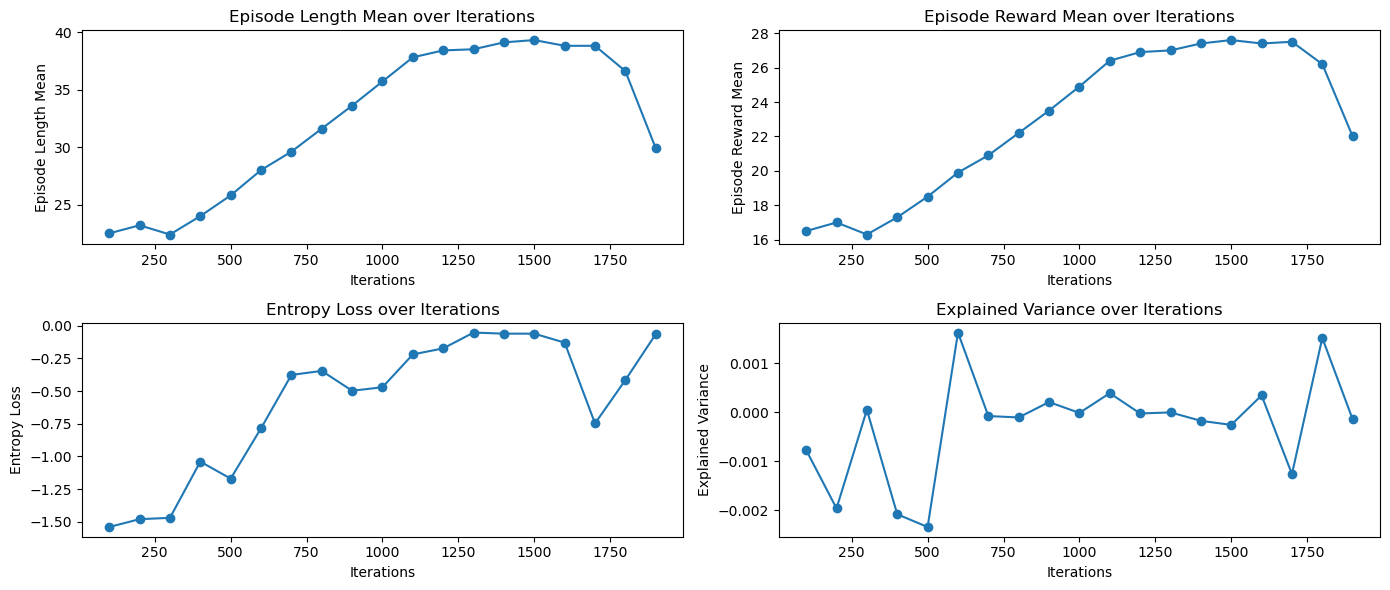

In [29]:
# Data for plotting
iterations = list(range(100, 2000, 100))  # Adjusting the range to produce 19 elements
ep_len_mean = [22.5, 23.2, 22.4, 24, 25.8, 28, 29.6, 31.6, 33.6, 35.7, 37.8, 38.4, 38.5, 39.1, 39.3, 38.8, 38.8, 36.6, 29.9]
ep_rew_mean = [16.5, 17, 16.3, 17.3, 18.5, 19.9, 20.9, 22.2, 23.5, 24.9, 26.4, 26.9, 27, 27.4, 27.6, 27.4, 27.5, 26.2, 22]
entropy_loss = [-1.54, -1.48, -1.47, -1.04, -1.17, -0.785, -0.377, -0.346, -0.498, -0.471, -0.22, -0.174, -0.0529, -0.0614, -0.0613, -0.13, -0.748, -0.416, -0.0652]
explained_variance = [-0.000769, -0.00196, 5.22e-05, -0.00208, -0.00234, 0.00163, -7.49e-05, -0.000103, 0.000211, -1.08e-05, 0.000393, -2.24e-05, 0, -0.000172, -0.000255, 0.000347, -0.00126, 0.00152, -0.000143]

# Plotting Episode Length Mean
plt.figure(figsize=(14, 6))
plt.subplot(2, 2, 1)
plt.plot(iterations, ep_len_mean, marker='o')
plt.xlabel('Iterations')
plt.ylabel('Episode Length Mean')
plt.title('Episode Length Mean over Iterations')

# Plotting Episode Reward Mean
plt.subplot(2, 2, 2)
plt.plot(iterations, ep_rew_mean, marker='o')
plt.xlabel('Iterations')
plt.ylabel('Episode Reward Mean')
plt.title('Episode Reward Mean over Iterations')

# Plotting Entropy Loss
plt.subplot(2, 2, 3)
plt.plot(iterations, entropy_loss, marker='o')
plt.xlabel('Iterations')
plt.ylabel('Entropy Loss')
plt.title('Entropy Loss over Iterations')

# Plotting Explained Variance
plt.subplot(2, 2, 4)
plt.plot(iterations, explained_variance, marker='o')
plt.xlabel('Iterations')
plt.ylabel('Explained Variance')
plt.title('Explained Variance over Iterations')

plt.tight_layout()
plt.show()

**Training Progress Metrics**

**Episode Length Mean (ep_len_mean):**

- The average episode length gradually increases over time, indicating that the agent is learning to survive longer in the environment. This metric starts at 22.5 and peaks around 39.4 before dropping to 29.9. This suggests that the agent is learning more efficient strategies but also experiencing variability.

**Episode Reward Mean (ep_rew_mean):**

- The average reward per episode shows a similar trend to the episode length, increasing from 16.5 to 27.7 before declining to 22. This reflects the agent's improved performance over time, with more rewards being accumulated. However, the final decline may indicate overfitting or a challenging learning plateau.

**Frames Per Second (fps):**

- The FPS remains consistent at around 5-6, suggesting the computational load and rendering time are steady throughout the training.

**Entropy Loss (entropy_loss):**

- Entropy loss generally decreases, indicating that the agent is becoming more certain in its action choices, reducing exploration over time.

**Explained Variance (explained_variance):**

- The explained variance metric is consistently close to zero and sometimes negative, indicating that the value function is not accurately predicting the returns. This might suggest that the value function needs further tuning or that the problem is particularly challenging.

**Policy Loss (policy_loss):**

- The policy loss fluctuates significantly during training, reflecting the adjustments in the agent's policy. The final values near zero suggest stabilization in policy updates.

**Value Loss (value_loss):**

- The value loss also fluctuates but generally decreases, indicating improvements in the value function approximation. However, some very low final values could indicate overfitting or numerical issues.

**Evaluation Mean Reward:**

- The evaluation shows a mean reward of approximately 11.7 with a high standard deviation of about 7.97, suggesting variability in performance. The lower mean reward during evaluation compared to training might indicate that the agent's performance is less robust when facing unseen situations.


## Custom Reward and Tuned Hyperparameters

In [53]:
import gymnasium as gym
import highway_env
from highway_env.envs.highway_env import HighwayEnv
from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from gymnasium import spaces

# Custom Highway Environment
class CustomHighwayEnv(HighwayEnv):
    def __init__(self, config=None):
        super().__init__(config)
        self.action_space = spaces.Discrete(5)  # Adjust this according to the environment's requirements
        
        # Let's inspect the observation space produced by the environment
        dummy_env = gym.make("highway-v0")
        dummy_env.configure(config)
        obs, _ = dummy_env.reset()  # Update to unpack the tuple correctly
        print(f"Observation shape: {obs.shape}")  # Add this line to inspect the observation shape
        dummy_env.close()
        
        # Define the observation space based on the actual shape
        self.observation_space = spaces.Box(low=-1, high=1, shape=obs.shape, dtype=float)
        
    def compute_reward(self, action):
        reward = 0
        speed_reward = self.vehicle.speed / self.config["reward_speed_range"][1]
        reward += speed_reward
        
        if self.vehicle.crashed:
            reward += self.config["collision_reward"]
        
        return reward

gym.envs.register(
        id='CustomHighway-v1',
        entry_point='__main__:CustomHighwayEnv',
    )

# Custom configuration
custom_config = {
    "lanes_count": 10,
    "vehicles_count": 50,
    "duration": 120,
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "initial_spacing": 2,
    "observation": {"type": "Kinematics"},
    "action": {"type": "DiscreteMetaAction"},
    "collision_reward": -10,  # High custom collision penalty
    "reward_speed_range": [20, 30],
    "simulation_frequency": 15,
    "policy_frequency": 1,
    "screen_width": 800,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False
}

# Initialize the custom environment with the configuration
def make_custom_env():
    env = gym.make('CustomHighway-v1')
    env.unwrapped.configure(custom_config)
    return Monitor(env)

# Vectorize environment
vec_env = make_vec_env(make_custom_env, n_envs=5)

# Hyperparameter tuning
learning_rate = 0.0005
gamma = 0.98

# Initialize and train the A2C model with tuned hyperparameters
a2c_model = A2C("MlpPolicy", vec_env, learning_rate=learning_rate, gamma=gamma, verbose=1)
a2c_model.learn(total_timesteps=100000, log_interval=100)
a2c_model.save("a2c_highway_custom")

# Evaluate the A2C model
mean_reward, std_reward = evaluate_policy(a2c_model, vec_env, n_eval_episodes=30)
print(f"A2C Mean reward: {mean_reward} +/- {std_reward}")

/Users/manuelgoncalves/anaconda3/lib/python3.11/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment CustomHighway-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/Users/manuelgoncalves/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(
/Users/manuelgoncalves/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logge

Observation shape: (5, 5)
Observation shape: (5, 5)
Observation shape: (5, 5)
Observation shape: (5, 5)
Observation shape: (5, 5)
Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 39.7     |
|    ep_rew_mean        | 37.4     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 395      |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -1.08    |
|    explained_variance | -0.00341 |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | 2.31     |
|    value_loss         | 5.31     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 53.3     |
|    ep_rew_mean        | 50.5     |
| time/                 |          |
|    fps                | 6        |
| 

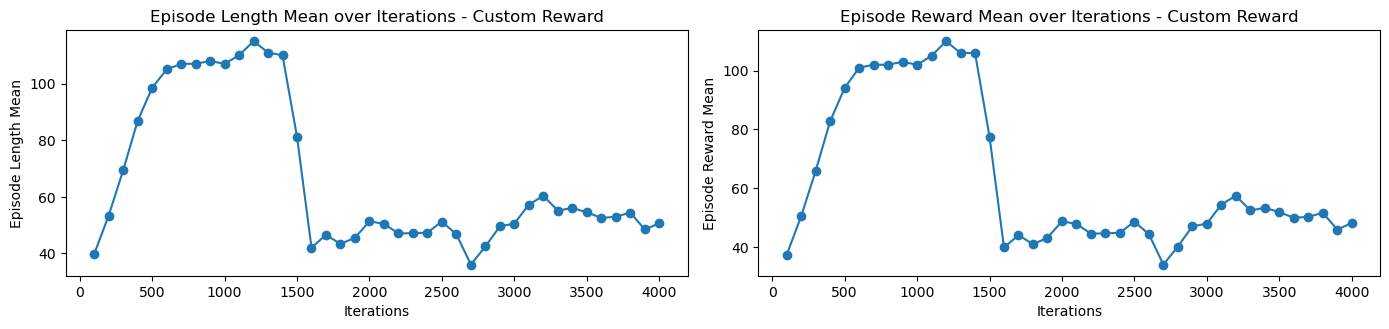

In [56]:
# Data extracted from the training logs
iterations = list(range(100, 4100, 100))
ep_len_mean = [39.7, 53.3, 69.3, 86.8, 98.5, 105, 107, 107, 108, 107, 110, 115, 111, 110, 81.2, 42, 46.5, 43.3, 45.5, 51.3, 50.4, 47, 47.1, 47.3, 51.2, 46.7, 36, 42.4, 49.5, 50.5, 57.2, 60.3, 55.1, 56, 54.5, 52.5, 52.9, 54.4, 48.4, 50.6]
ep_rew_mean = [37.4, 50.5, 65.9, 82.8, 94.1, 101, 102, 102, 103, 102, 105, 110, 106, 106, 77.6, 39.9, 44.1, 41, 43.2, 48.8, 47.9, 44.6, 44.7, 44.9, 48.7, 44.4, 34.1, 40.2, 47.1, 48, 54.5, 57.5, 52.5, 53.4, 51.9, 50, 50.3, 51.7, 46, 48.2]

# Plotting Episode Length Mean
plt.figure(figsize=(14, 6))
plt.subplot(2, 2, 1)
plt.plot(iterations, ep_len_mean, marker='o')
plt.xlabel('Iterations')
plt.ylabel('Episode Length Mean')
plt.title('Episode Length Mean over Iterations - Custom Reward')

# Plotting Episode Reward Mean
plt.subplot(2, 2, 2)
plt.plot(iterations, ep_rew_mean, marker='o')
plt.xlabel('Iterations')
plt.ylabel('Episode Reward Mean')
plt.title('Episode Reward Mean over Iterations - Custom Reward')

plt.tight_layout()
plt.show()

**Episode Length Mean over Iterations:**

- Initial Increase: The episode length mean shows a significant increase from the beginning up to around iteration 1000. This indicates that the agent is learning to navigate the environment more effectively, avoiding collisions and maintaining its position on the highway.
- Sharp Drop: Around iteration 1500, there is a sharp drop in the episode length mean. This suggests that the agent may have encountered a new challenge or overfitting to specific scenarios, leading to reduced performance.
- Recovery and Fluctuation: After the drop, there is a recovery and fluctuation phase where the episode length mean stabilizes but with considerable variability. This indicates that the agent is still learning and adjusting its strategy.

**Episode Reward Mean over Iterations:**

- Initial Increase: Similar to the episode length, the episode reward mean increases significantly up to around iteration 1000. This indicates that the agent is learning to maximize the custom reward function, which rewards speed and penalizes collisions.
- Sharp Drop: The episode reward mean also shows a sharp drop around iteration 1500, mirroring the trend in episode length. This could be due to the same factors affecting the episode length, such as changes in the environment dynamics or learning instability.
- Recovery and Fluctuation: Post-drop, the reward mean recovers and stabilizes with fluctuations. The agent's performance in terms of reward is similar to its performance in episode length, suggesting it is still refining its policy.

**Contextual Analysis with the Code**

The custom Highway environment and reward system are defined as follows:

**Custom Environment:**

- The environment is based on the HighwayEnv class, with a custom reward function.
- The compute_reward function rewards the agent for maintaining a high speed within a specified range and penalizes for collisions with a high negative reward.

**Custom Configuration:**

- The configuration includes a high penalty for collisions (collision_reward: -10), which strongly discourages crashes.
- The reward speed range is set between 20 and 30, encouraging the agent to maintain speeds within this range.

**Training Setup:**

- The environment is vectorized to allow parallel training (n_envs=5), speeding up the learning process.
- The A2C model is initialized with a learning rate of 0.0005 and a gamma (discount factor) of 0.98, parameters chosen for balancing exploration and exploitation.


In [62]:
# Custom configuration
custom_config_high_speed = {
    "lanes_count": 10,
    "vehicles_count": 50,
    "duration": 40, # Back down to 40 seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "initial_spacing": 2,
    "observation": {"type": "Kinematics"},
    "action": {"type": "DiscreteMetaAction"},
    "collision_reward": -10,  # High custom collision penalty
    "reward_speed_range": [40, 50], # Higher speeds
    "simulation_frequency": 15,
    "policy_frequency": 1,
    "screen_width": 800,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False
}

# Initialize the custom environment with the configuration
def make_custom_env():
    env = gym.make('CustomHighway-v1')
    env.unwrapped.configure(custom_config_high_speed)
    return Monitor(env)

# Vectorize environment
vec_env = make_vec_env(make_custom_env, n_envs=5)

# Hyperparameter tuning
learning_rate = 0.0005
gamma = 0.98

# Initialize and train the A2C model with tuned hyperparameters
a2c_model_high_speed = A2C("MlpPolicy", vec_env, learning_rate=learning_rate, gamma=gamma, verbose=1)
a2c_model_high_speed.learn(total_timesteps=10000, log_interval=100)
a2c_model_high_speed.save("a2c_highway_high_speed")

# Evaluate the A2C model
mean_reward, std_reward = evaluate_policy(a2c_model_high_speed, vec_env, n_eval_episodes=30)
print(f"A2C Mean reward: {mean_reward} +/- {std_reward}")

/Users/manuelgoncalves/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(
/Users/manuelgoncalves/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(
/Users/manuelgoncalves/anaconda3/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.c

Observation shape: (5, 5)
Observation shape: (5, 5)
Observation shape: (5, 5)
Observation shape: (5, 5)
Observation shape: (5, 5)
Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 28.3     |
|    ep_rew_mean        | 26.6     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 399      |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -0.775   |
|    explained_variance | -0.0123  |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | 0.981    |
|    value_loss         | 5.4      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 36       |
|    ep_rew_mean        | 34.3     |
| time/                 |          |
|    fps                | 6        |
| 

## Hyperparameter Tuning

In [84]:
import optuna

# Optuna is a powerful hyperparameter optimization framework that can automate the search process.
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)

    # Initialize and train the A2C model with the suggested hyperparameters
    a2c_model = A2C("MlpPolicy", vec_env, learning_rate=learning_rate, gamma=gamma, verbose=1)
    a2c_model.learn(total_timesteps=5000, log_interval=50) # Lower timesteps for faster computations
    
    # Evaluate the A2C model
    mean_reward, std_reward = evaluate_policy(a2c_model, vec_env, n_eval_episodes=30)
    
    return mean_reward

# Optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print best parameters
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-06-15 00:58:40,858] A new study created in memory with name: no-name-a65baf32-9f12-4741-9f1b-8123bae0967c
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 16       |
|    ep_rew_mean        | 14.4     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 50       |
|    time_elapsed       | 198      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -1.61    |
|    explained_variance | 0.0119   |
|    learning_rate      | 5.71e-05 |
|    n_updates          | 49       |
|    policy_loss        | 2.16     |
|    value_loss         | 4.22     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 16.3     |
|    ep_rew_mean        | 14.8     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 398      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 01:15:11,565] Trial 0 finished with value: 38.24056413333334 and parameters: {'learning_rate': 5.705895244595119e-05, 'gamma': 0.9481378920959003}. Best is trial 0 with value: 38.24056413333334.
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 26       |
|    ep_rew_mean        | 24.4     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 50       |
|    time_elapsed       | 198      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -0.598   |
|    explained_variance | -0.00374 |
|    learning_rate      | 0.00388  |
|    n_updates          | 49       |
|    policy_loss        | 0.434    |
|    value_loss         | 0.845    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 29.7     |
|    ep_rew_mean        | 28.1     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 397      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 01:31:36,133] Trial 1 finished with value: 33.539188466666666 and parameters: {'learning_rate': 0.0038775238054124077, 'gamma': 0.9753916115246546}. Best is trial 0 with value: 38.24056413333334.
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 15.5     |
|    ep_rew_mean        | 14       |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 50       |
|    time_elapsed       | 198      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -1.51    |
|    explained_variance | 0.0379   |
|    learning_rate      | 0.000313 |
|    n_updates          | 49       |
|    policy_loss        | 3.48     |
|    value_loss         | 5.88     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22.1     |
|    ep_rew_mean        | 20.5     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 397      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 01:48:00,425] Trial 2 finished with value: 38.29135773333335 and parameters: {'learning_rate': 0.0003130884330945705, 'gamma': 0.9694318929639724}. Best is trial 2 with value: 38.29135773333335.
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 15.9     |
|    ep_rew_mean        | 14.3     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 50       |
|    time_elapsed       | 199      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -1.61    |
|    explained_variance | -0.0357  |
|    learning_rate      | 1.07e-05 |
|    n_updates          | 49       |
|    policy_loss        | 4.16     |
|    value_loss         | 8.62     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 14.2     |
|    ep_rew_mean        | 12.7     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 398      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 11:40:47,940] Trial 3 finished with value: 37.30335070000001 and parameters: {'learning_rate': 1.0710419700306275e-05, 'gamma': 0.9806315099685909}. Best is trial 2 with value: 38.29135773333335.
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 25.6     |
|    ep_rew_mean        | 23.9     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 50       |
|    time_elapsed       | 198      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -0.0128  |
|    explained_variance | -0.136   |
|    learning_rate      | 0.00714  |
|    n_updates          | 49       |
|    policy_loss        | 1.81e-05 |
|    value_loss         | 0.000209 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 31.5     |
|    ep_rew_mean        | 29.8     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 396      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 11:57:10,265] Trial 4 finished with value: 37.03830660000001 and parameters: {'learning_rate': 0.007141641615338643, 'gamma': 0.9671336323548589}. Best is trial 2 with value: 38.29135773333335.
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 14.9     |
|    ep_rew_mean        | 13.4     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 50       |
|    time_elapsed       | 198      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -1.6     |
|    explained_variance | 0.0305   |
|    learning_rate      | 0.000116 |
|    n_updates          | 49       |
|    policy_loss        | 1.63     |
|    value_loss         | 4.7      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 17.4     |
|    ep_rew_mean        | 15.9     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 397      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 12:13:35,515] Trial 5 finished with value: 38.30405613333335 and parameters: {'learning_rate': 0.00011613903213086886, 'gamma': 0.947599909537483}. Best is trial 5 with value: 38.30405613333335.
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 14.7     |
|    ep_rew_mean        | 13.2     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 50       |
|    time_elapsed       | 199      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -1.61    |
|    explained_variance | 0.0538   |
|    learning_rate      | 1.05e-05 |
|    n_updates          | 49       |
|    policy_loss        | 3.73     |
|    value_loss         | 7.1      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 14.8     |
|    ep_rew_mean        | 13.3     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 398      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 12:30:03,901] Trial 6 finished with value: 37.147442433333346 and parameters: {'learning_rate': 1.0547555410520458e-05, 'gamma': 0.9956158192361955}. Best is trial 5 with value: 38.30405613333335.
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 14.9     |
|    ep_rew_mean        | 13.4     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 50       |
|    time_elapsed       | 200      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -1.61    |
|    explained_variance | 0.101    |
|    learning_rate      | 0.000106 |
|    n_updates          | 49       |
|    policy_loss        | 3.4      |
|    value_loss         | 5.31     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 15.6     |
|    ep_rew_mean        | 14.1     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 402      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 12:46:37,062] Trial 7 finished with value: 38.26455000000001 and parameters: {'learning_rate': 0.00010577655932754284, 'gamma': 0.9275658069578914}. Best is trial 5 with value: 38.30405613333335.
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 15.6     |
|    ep_rew_mean        | 14       |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 50       |
|    time_elapsed       | 198      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -1.61    |
|    explained_variance | 0.0918   |
|    learning_rate      | 1.23e-05 |
|    n_updates          | 49       |
|    policy_loss        | 4.08     |
|    value_loss         | 8.36     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 15.6     |
|    ep_rew_mean        | 14.1     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 397      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 13:03:02,694] Trial 8 finished with value: 36.991745800000004 and parameters: {'learning_rate': 1.2258422949665627e-05, 'gamma': 0.9874093054466296}. Best is trial 5 with value: 38.30405613333335.
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 17       |
|    ep_rew_mean        | 15.4     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 50       |
|    time_elapsed       | 198      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -1.61    |
|    explained_variance | 0.0387   |
|    learning_rate      | 8.43e-05 |
|    n_updates          | 49       |
|    policy_loss        | 3.51     |
|    value_loss         | 6.28     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 16.2     |
|    ep_rew_mean        | 14.6     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 397      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 13:19:27,249] Trial 9 finished with value: 37.2948851 and parameters: {'learning_rate': 8.434881064832178e-05, 'gamma': 0.9463314528485659}. Best is trial 5 with value: 38.30405613333335.
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 31.2     |
|    ep_rew_mean        | 29.6     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 50       |
|    time_elapsed       | 198      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -0.603   |
|    explained_variance | 0.272    |
|    learning_rate      | 0.00143  |
|    n_updates          | 49       |
|    policy_loss        | 0.00676  |
|    value_loss         | 0.000886 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 35.3     |
|    ep_rew_mean        | 33.7     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 397      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 13:35:53,119] Trial 10 finished with value: 37.21693096666667 and parameters: {'learning_rate': 0.0014314206315406992, 'gamma': 0.9059654193257299}. Best is trial 5 with value: 38.30405613333335.
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 22       |
|    ep_rew_mean        | 20.5     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 50       |
|    time_elapsed       | 199      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -1.49    |
|    explained_variance | -0.0065  |
|    learning_rate      | 0.000518 |
|    n_updates          | 49       |
|    policy_loss        | 1.74     |
|    value_loss         | 6.74     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 25.4     |
|    ep_rew_mean        | 23.8     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 400      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 13:52:27,189] Trial 11 finished with value: 37.022292500000006 and parameters: {'learning_rate': 0.0005175399908428159, 'gamma': 0.9615586995646997}. Best is trial 5 with value: 38.30405613333335.
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 16.8     |
|    ep_rew_mean        | 15.3     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 50       |
|    time_elapsed       | 201      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -1.41    |
|    explained_variance | -0.0651  |
|    learning_rate      | 0.000316 |
|    n_updates          | 49       |
|    policy_loss        | 2.11     |
|    value_loss         | 2.14     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 23.2     |
|    ep_rew_mean        | 21.6     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 401      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 14:09:05,887] Trial 12 finished with value: 34.78074049999999 and parameters: {'learning_rate': 0.00031581434160324654, 'gamma': 0.924229210959447}. Best is trial 5 with value: 38.30405613333335.
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 16.1     |
|    ep_rew_mean        | 14.6     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 50       |
|    time_elapsed       | 202      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -1.58    |
|    explained_variance | 0.000938 |
|    learning_rate      | 0.000303 |
|    n_updates          | 49       |
|    policy_loss        | 2.58     |
|    value_loss         | 3.13     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 21.3     |
|    ep_rew_mean        | 19.7     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 405      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 14:25:50,608] Trial 13 finished with value: 37.622574666666665 and parameters: {'learning_rate': 0.0003028287034229343, 'gamma': 0.9379313309801055}. Best is trial 5 with value: 38.30405613333335.
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 14.8     |
|    ep_rew_mean        | 13.3     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 50       |
|    time_elapsed       | 203      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -1.61    |
|    explained_variance | 0.0299   |
|    learning_rate      | 3.28e-05 |
|    n_updates          | 49       |
|    policy_loss        | 4.55     |
|    value_loss         | 9.35     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.4     |
|    ep_rew_mean        | 10.9     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 414      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 14:41:56,814] Trial 14 finished with value: 20.707160366666663 and parameters: {'learning_rate': 3.279490743987714e-05, 'gamma': 0.9589390550153788}. Best is trial 5 with value: 38.30405613333335.
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 23.5     |
|    ep_rew_mean        | 21.9     |
| time/                 |          |
|    fps                | 5        |
|    iterations         | 50       |
|    time_elapsed       | 210      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -1.07    |
|    explained_variance | 0.0353   |
|    learning_rate      | 0.000867 |
|    n_updates          | 49       |
|    policy_loss        | 0.566    |
|    value_loss         | 0.313    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 27.5     |
|    ep_rew_mean        | 25.8     |
| time/                 |          |
|    fps                | 5        |
|    iterations         | 100      |
|    time_elapsed       | 425      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 14:59:34,760] Trial 15 finished with value: 38.26737186666667 and parameters: {'learning_rate': 0.0008673768032495008, 'gamma': 0.9331150604550443}. Best is trial 5 with value: 38.30405613333335.
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 14       |
|    ep_rew_mean        | 12.4     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 50       |
|    time_elapsed       | 205      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -1.6     |
|    explained_variance | -0.0908  |
|    learning_rate      | 0.000172 |
|    n_updates          | 49       |
|    policy_loss        | 1.29     |
|    value_loss         | 4.15     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 14.4     |
|    ep_rew_mean        | 12.8     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 409      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 15:16:34,075] Trial 16 finished with value: 37.05213376666667 and parameters: {'learning_rate': 0.00017192038749405802, 'gamma': 0.9070420598859347}. Best is trial 5 with value: 38.30405613333335.
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.1     |
|    ep_rew_mean        | 10.6     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 50       |
|    time_elapsed       | 202      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -0.792   |
|    explained_variance | 0.0422   |
|    learning_rate      | 0.00183  |
|    n_updates          | 49       |
|    policy_loss        | -0.544   |
|    value_loss         | 13.8     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 13.8     |
|    ep_rew_mean        | 12.3     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 404      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 15:33:19,383] Trial 17 finished with value: 38.288535866666685 and parameters: {'learning_rate': 0.0018250659574255126, 'gamma': 0.9689042258830688}. Best is trial 5 with value: 38.30405613333335.
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 16.3     |
|    ep_rew_mean        | 14.7     |
| time/                 |          |
|    fps                | 5        |
|    iterations         | 50       |
|    time_elapsed       | 211      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -1.61    |
|    explained_variance | 0.0663   |
|    learning_rate      | 3.73e-05 |
|    n_updates          | 49       |
|    policy_loss        | 3.45     |
|    value_loss         | 6.57     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 15.4     |
|    ep_rew_mean        | 13.9     |
| time/                 |          |
|    fps                | 5        |
|    iterations         | 100      |
|    time_elapsed       | 421      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 15:50:27,125] Trial 18 finished with value: 38.30546706666668 and parameters: {'learning_rate': 3.730852220297002e-05, 'gamma': 0.9560196736154805}. Best is trial 18 with value: 38.30546706666668.
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/var/folders/7t/zx4dtwrn069843pwqq5pz9bc0000gn/T/ipykernel_14939/2796400982.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)


Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 12.9     |
|    ep_rew_mean        | 11.5     |
| time/                 |          |
|    fps                | 5        |
|    iterations         | 50       |
|    time_elapsed       | 209      |
|    total_timesteps    | 1250     |
| train/                |          |
|    entropy_loss       | -1.61    |
|    explained_variance | -0.02    |
|    learning_rate      | 2.91e-05 |
|    n_updates          | 49       |
|    policy_loss        | 2.85     |
|    value_loss         | 5.24     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 14.7     |
|    ep_rew_mean        | 13.2     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 100      |
|    time_elapsed       | 415      |
|    total_timesteps    | 2500     |
| train/             

[I 2024-06-15 16:08:25,158] Trial 19 finished with value: 37.19929426666667 and parameters: {'learning_rate': 2.905281024216584e-05, 'gamma': 0.9174983685827978}. Best is trial 18 with value: 38.30546706666668.


Best trial:
  Value: 38.30546706666668
  Params: 
    learning_rate: 3.730852220297002e-05
    gamma: 0.9560196736154805


In [85]:
# Custom configuration
custom_config_hypertuning = {
    "lanes_count": 10,
    "vehicles_count": 50,
    "duration": 40, # Back down to 40 seconds
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "initial_spacing": 2,
    "observation": {"type": "Kinematics"},
    "action": {"type": "DiscreteMetaAction"},
    "collision_reward": -10,  # High custom collision penalty
    "reward_speed_range": [40, 50], # Higher speeds
    "simulation_frequency": 15,
    "policy_frequency": 1,
    "screen_width": 800,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": False,
    "render_agent": True,
    "offscreen_rendering": False
}

# Hyperparameter tuning
learning_rate = 3.730852220297002e-05
gamma = 0.9560196736154805

# Initialize and train the A2C model with tuned hyperparameters
a2c_model_tuning = A2C("MlpPolicy", vec_env, learning_rate=learning_rate, gamma=gamma, verbose=1)
a2c_model_tuning.learn(total_timesteps=10000, log_interval=100)
a2c_model_tuning.save("a2c_highway_tuning")

# Evaluate the A2C model
mean_reward, std_reward = evaluate_policy(a2c_model_tuning, vec_env, n_eval_episodes=30)
print(f"A2C Mean reward: {mean_reward} +/- {std_reward}")

Using cpu device
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 18.5     |
|    ep_rew_mean        | 16.9     |
| time/                 |          |
|    fps                | 5        |
|    iterations         | 100      |
|    time_elapsed       | 433      |
|    total_timesteps    | 2500     |
| train/                |          |
|    entropy_loss       | -1.61    |
|    explained_variance | -0.0836  |
|    learning_rate      | 3.73e-05 |
|    n_updates          | 99       |
|    policy_loss        | 3.02     |
|    value_loss         | 5.68     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 15       |
|    ep_rew_mean        | 13.5     |
| time/                 |          |
|    fps                | 5        |
|    iterations         | 200      |
|    time_elapsed       | 927      |
|    total_timesteps    | 5000     |
| train/             